In [1]:
import sys 
import glob
import os
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.interpolate import make_interp_spline,BSpline

from scipy.stats import zscore 
from scipy.interpolate import UnivariateSpline
from skimage.exposure import match_histograms

from PIL import Image
from imageio import imwrite

import yaml      

In [2]:
exp_folder = '../z-analysis/analysis'
alignment_channel = 561 

exp_folder = os.path.normpath(exp_folder) + "\\"
storm_merged_path = exp_folder + 'unaligned\\storm_merged\\'
conv_align_path = exp_folder + 'unaligned\\conv_{}\\'.format(str(alignment_channel))

storm_merged_files = glob.glob(storm_merged_path + '*.tif')
num_merged_images = len(storm_merged_files) 

wga_files = glob.glob(conv_align_path + '*.tif')
num_wga_images = len(wga_files) 

In [3]:
wga_files

['..\\z-analysis\\analysis\\unaligned\\conv_561\\000.tif',
 '..\\z-analysis\\analysis\\unaligned\\conv_561\\001.tif',
 '..\\z-analysis\\analysis\\unaligned\\conv_561\\002.tif',
 '..\\z-analysis\\analysis\\unaligned\\conv_561\\003.tif']

In [4]:
def cal_hist(wgafile,num_images):
    print(wgafile)
    A = mpimg.imread(wgafile)
    hist,bins = np.histogram(A.ravel(),255,[1,255])
    return hist

print('Loading in analysis config') 
    
# Read in parameters from yaml file 
with open('./configs/bead_analysis_params.yml') as f:
        config = yaml.load(f)

shape = (config['shape_h'], config['shape_w']) 

exp_folder = os.path.normpath(exp_folder) + "\\"
storm_merged_path = exp_folder + 'unaligned\\storm_merged\\'
conv_align_path = exp_folder + 'unaligned\\conv_{}\\'.format(str(alignment_channel))

storm_merged_files = glob.glob(storm_merged_path + '*.tif')
num_merged_images = len(storm_merged_files) 

wga_files = glob.glob(conv_align_path + '*.tif')
num_wga_images = len(wga_files) 

assert num_merged_images == num_wga_images, "Number of images must match!"
num_images = num_merged_images

hy3c = np.zeros((num_images, 255))
hy4c = np.zeros((num_images, 255))

hy3cb = np.zeros((num_images, 255))
hy4cb = np.zeros((num_images, 255))

print('Calculating histograms!') 

print(num_images)
for i in range(num_images): 
    hy3c[i] = cal_hist(storm_merged_files[i], num_images) # storm_merged 
    hy4c[i] = cal_hist(wga_files[i], num_images) # conv_561 

# Normalizing counts to 0-1 range 
hy3cb = hy3c / hy3c.sum(axis=1, keepdims=True)        
hy4cb = hy4c / hy4c.sum(axis=1, keepdims=True)   

Loading in analysis config
Calculating histograms!
4
..\z-analysis\analysis\unaligned\storm_merged\000.tif


C:\Program Files\Python36\Lib\site-packages\ipykernel_launcher.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # This is added back by InteractiveShellApp.init_path()


..\z-analysis\analysis\unaligned\conv_561\000.tif
..\z-analysis\analysis\unaligned\storm_merged\001.tif
..\z-analysis\analysis\unaligned\conv_561\001.tif
..\z-analysis\analysis\unaligned\storm_merged\002.tif
..\z-analysis\analysis\unaligned\conv_561\002.tif
..\z-analysis\analysis\unaligned\storm_merged\003.tif
..\z-analysis\analysis\unaligned\conv_561\003.tif


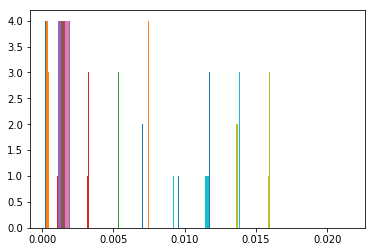

In [7]:
plt.hist(hy4cb)
plt.show()

In [8]:
chan = hy4cb 
varuse4 = np.zeros([num_images, 255])

x_hist = np.arange(1,255) 
x_sections = np.arange(0, num_images)

print('Thresholding!!') 

for i in range(255): 
    zthresh = 3 
    curr_param = chan[:, i] # Distribution of channel i values across all images 

    mean = np.mean(curr_param, axis=0)
    sd = np.std(curr_param, axis=0)        
    distance_from_mean = abs(chan[:, i] - mean)
    mask = distance_from_mean < zthresh * sd

    # Select which sections can be used for smooth interpolation 
    currfitx = x_sections[mask]
    currfity = curr_param[mask] 

    # currfitx = (currfitx - np.mean(currfitx)) / (np.std(currfitx) + 0.00001)
    # currfity = (currfity - np.mean(currfity)) / (np.std(currfity) + 0.00001)

    spl = UnivariateSpline(currfitx, currfity)
    spl.set_smoothing_factor(0.9) 

    varuse4[:, i] = spl(np.arange(0,num_images))

path4 = exp_folder + 'unaligned\\for_align\\'
path4a = exp_folder + 'unaligned\\for_align_ds\\'


print('Saving out new images!') 

if not os.path.exists(path4):
    os.mkdir(path4)
if not os.path.exists(path4a): 
    os.mkdir(path4a)

hgram4 = varuse4 / varuse4.sum(axis=0, keepdims=True) # Normalize over the channels for each image 

Thresholding!!
Saving out new images!


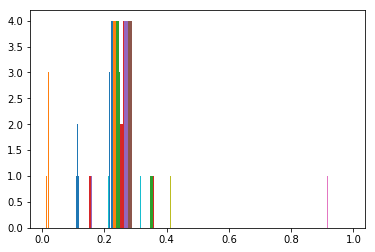

In [9]:
plt.hist(hgram4)
plt.show()

In [32]:
i = 1

"""
A = (imread([path3 stormfiles(i,1).name]));
A4 = A(:,:,1);

hgram4a = cat(1, numel(find(A4==0)),
              hgram4*numel(find(A4)));

"""

A = mpimg.imread(wga_files[i]) 
hist,bins = np.histogram(A.ravel(),256,[0,255])
hist_cum = np.cumsum(hist)
a = np.array(hist[0])
b = hgram4*(sum(hist)-hist[0])
hgram4a = np.concatenate((a,b),axis=None)

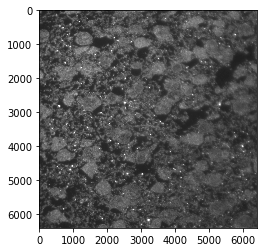

In [33]:
plt.imshow(A, cmap='gray')

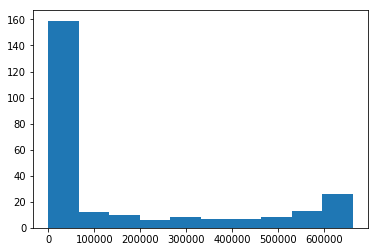

In [34]:
plt.hist(hist)
plt.show()

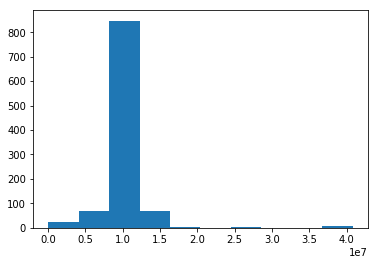

In [35]:
plt.hist(hgram4a)
plt.show()

In [36]:
import numpy as np

def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    # template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [39]:
out = hist_match(A, hgram4a)
out[A < 1] = 0

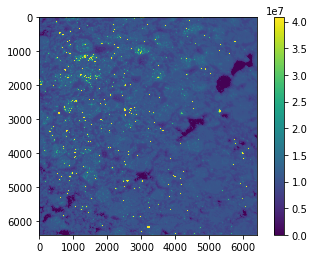

In [41]:
plt.imshow(out)
plt.colorbar()